In [31]:
import numpy as np
import pandas as pd
import os
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib

#setting the directory on my computer
os.chdir('/Users/zihan/Desktop/spider_wd')
#load the data 
train = pd.read_csv('HousePrice.csv' )

In [32]:
#drop the id column as it is useless for prediction 
train.drop(['Id'], axis=1, inplace=True)

#drop the outlier with a very large GrLivArea but a very low rice
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train.reset_index(drop=True, inplace=True)


In [33]:
#log transform the target variable 'SalePrice'
train["SalePrice"] = np.log1p(train["SalePrice"])

X = train.drop(['SalePrice'], axis=1)
y = train['SalePrice'].reset_index(drop=True)


In [5]:
# filling missing values of categorical features with 'None' meaning 'don't have'
X["PoolQC"] = X["PoolQC"].fillna("None")
X["MiscFeature"] = X["MiscFeature"].fillna("None")
X["Alley"] = X["Alley"].fillna("None")
X["Fence"] = X["Fence"].fillna("None")
X["FireplaceQu"] = X["FireplaceQu"].fillna("None")
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    X[col] = X[col].fillna('None')
X["MasVnrType"] = X["MasVnrType"].fillna("None")
X['MSSubClass'] = X['MSSubClass'].fillna("None")


In [6]:
# filling missing values of features with median of groups
X["LotFrontage"] = X.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))


#filling missing values of numeric features with 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    X[col] = X[col].fillna(0)


In [7]:
#filling missing values of features with mode
X['MSZoning'] = X['MSZoning'].fillna(X['MSZoning'].mode()[0])
X['Electrical'] = X['Electrical'].fillna(X['Electrical'].mode()[0])
X['KitchenQual'] = X['KitchenQual'].fillna(X['KitchenQual'].mode()[0])
X['Exterior1st'] = X['Exterior1st'].fillna(X['Exterior1st'].mode()[0])
X['Exterior2nd'] = X['Exterior2nd'].fillna(X['Exterior2nd'].mode()[0])
X['SaleType'] = X['SaleType'].fillna(X['SaleType'].mode()[0])

X["Functional"] = X["Functional"].fillna("Typ")

In [8]:
#drop useless feature 'Utilities' as it is same for all samples
X = X.drop(['Utilities'], axis=1)


In [9]:
#check the missing values 
missing_data = pd.DataFrame({'Missing Ratio' :((X.isnull().sum() / len(X)) * 100)})
print(missing_data)

               Missing Ratio
MSSubClass               0.0
MSZoning                 0.0
LotFrontage              0.0
LotArea                  0.0
Street                   0.0
Alley                    0.0
LotShape                 0.0
LandContour              0.0
LotConfig                0.0
LandSlope                0.0
Neighborhood             0.0
Condition1               0.0
Condition2               0.0
BldgType                 0.0
HouseStyle               0.0
OverallQual              0.0
OverallCond              0.0
YearBuilt                0.0
YearRemodAdd             0.0
RoofStyle                0.0
RoofMatl                 0.0
Exterior1st              0.0
Exterior2nd              0.0
MasVnrType               0.0
MasVnrArea               0.0
ExterQual                0.0
ExterCond                0.0
Foundation               0.0
BsmtQual                 0.0
BsmtCond                 0.0
...                      ...
HalfBath                 0.0
BedroomAbvGr             0.0
KitchenAbvGr  

In [10]:
# transfer numeric variables which are categorical 
X['MSSubClass'] = X['MSSubClass'].apply(str)
X['OverallCond'] = X['OverallCond'].astype(str)
X['YrSold'] = X['YrSold'].astype(str)
X['MoSold'] = X['MoSold'].astype(str)

In [11]:
# boxcox transformation of skewed features
numeric_f = X.dtypes[X.dtypes != "object"].index
skewed_f = X[numeric_f].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_f = skewed_f[abs(skewed_f) > 0.5]
from scipy.special import boxcox1p
skewed_features = skewed_f.index
lam = 0.15
count = 0
for f in skewed_features:
    X[f] = boxcox1p(X[f], lam)
    count += 1

In [12]:
#get the dummy categorical features
X_dummy = pd.get_dummies(X).reset_index(drop=True)
X_dummy.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.831328,19.212182,7,14.187527,14.187527,8.059126,11.170327,0.0,7.483296,11.692623,...,0,0,0,1,0,0,0,0,1,0
1,6.221214,19.712205,6,14.145138,14.145138,0.000000,12.062832,0.0,8.897844,12.792276,...,0,0,0,1,0,0,0,0,1,0
2,5.914940,20.347241,7,14.184404,14.185966,7.646538,10.200343,0.0,9.917060,11.892039,...,0,0,0,1,0,0,0,0,1,0
3,5.684507,19.691553,7,14.047529,14.135652,0.000000,8.274266,0.0,10.468500,11.354094,...,0,0,0,1,1,0,0,0,0,0
4,6.314735,21.325160,8,14.182841,14.182841,9.391827,10.971129,0.0,10.221051,12.510588,...,0,0,0,1,0,0,0,0,1,0


In [17]:
# Using random forest to get feature importance
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=7)
forest.fit(X_dummy, y) 
importances = pd.Series(forest.feature_importances_, index = X_dummy.columns)

In [15]:
#plot the importance of features for top 10 and last 10
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp = pd.concat([importances.sort_values().head(10), importances.sort_values().tail(10)])
imp.plot(kind = "barh")


AttributeError: 'Series' object has no attribute 'columns'

In [16]:
# find the number of features whose importance is 0
print("RF picked " + str(sum(importances != 0)) + " variables and assign importances of the other " +  str(sum(importances == 0)) + " variables to zero")


RF picked 296 variables and assign importances of the other 40 variables to zero


In [24]:
# feature selection
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(forest, prefit=True, max_features=30)
feature_idx = model.get_support()
feature_names = X_dummy.columns[feature_idx]
X_new = model.transform(X_dummy)
pd.DataFrame(X_new, columns= feature_names)
print (feature_names)


Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'MSZoning_RM', 'CentralAir_Y'],
      dtype='object')


In [25]:
#Validation function
kfolds = KFold(n_splits=10, shuffle=True, random_state=7)

# model trained by all features
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_dummy, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

# model trained by seleted features
def cv_rmse2(model):
    rmse2 = np.sqrt(-cross_val_score(model, X_new, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse2)

In [26]:
# Lasso regression model
alphas_lasso = [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
lasso = LassoCV(max_iter=1e6, alphas=alphas_lasso, random_state=7, cv=kfolds)
# calculate the score of lasso
score1 = cv_rmse(lasso)
score2 = cv_rmse2(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score1.mean(), score1.std()), )
print("LASSO with selected features: {:.4f} ({:.4f})\n".format(score2.mean(), score2.std()), )


LASSO: 0.1111 (0.0144)

LASSO with selected features: 0.1367 (0.0128)



In [20]:
# ridge regression model
alphas_ridge = [0.1, 0.5, 1, 5, 10, 15]
ridge = RidgeCV(alphas=alphas_ridge, cv=kfolds)
score1 = cv_rmse(ridge)
score2 = cv_rmse2(ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score1.mean(), score1.std()), )
print("Ridge with selected features : {:.4f} ({:.4f})\n".format(score2.mean(), score2.std()), )

Ridge: 0.1124 (0.0141)

Ridge with selected features : 0.1367 (0.0129)



In [21]:
#kernel ridge regression model
alphas_kernel = [1, 5, 10, 15, 20, 25, 30]
kernel = KernelRidge(alpha= alphas_kernel, kernel='polynomial', degree= 2, coef0=25)
score1 = cv_rmse(kernel)
score2 = cv_rmse2(kernel)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score1.mean(), score1.std()))
print("Kernel Ridge score with selected features: {:.4f} ({:.4f})\n".format(score2.mean(), score2.std()))

Kernel Ridge score: 0.1223 (0.0105)

Kernel Ridge score with selected features: 0.1356 (0.0117)



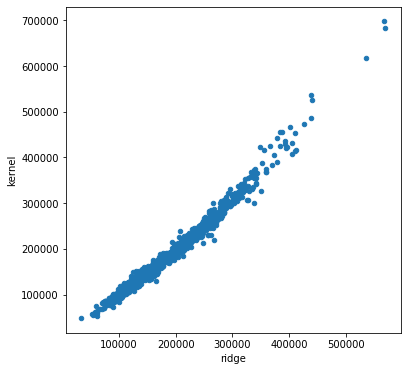

In [22]:
#comparing the predictions of ridge model and kernel ridge model fitted by selected features 
ridge_fit = RidgeCV(alphas = alphas_ridge).fit(X_new, y)
kernel_fit = KernelRidge(alpha= alphas_kernel, kernel='polynomial', degree= 2, coef0=25).fit(X_new, y) 
ridge_pred = np.expm1(ridge_fit.predict(X_new))
kernel_pred = np.expm1(kernel_fit.predict(X_new))
predictions = pd.DataFrame({"ridge":ridge_pred, "kernel":kernel_pred})
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
predictions.plot(x = "ridge", y = "kernel", kind = "scatter")

In [23]:
# Gradient boosting regression model
from sklearn.ensemble import GradientBoostingRegressor
GBoost = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.02,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =7)
score1 = cv_rmse(GBoost)
score2 = cv_rmse2(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score1.mean(), score1.std()))
print("Gradient Boosting score with selected features: {:.4f} ({:.4f})\n".format(score2.mean(), score2.std()))


Gradient Boosting score: 0.1141 (0.0116)

Gradient Boosting score with selected features: 0.1396 (0.0127)

